In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import keras
from keras.layers import UpSampling2D, Conv2D, Activation,Dropout
from keras.layers.convolutional import Conv2DTranspose
from keras import Model
import tensorflow as tf

Using TensorFlow backend.


In [3]:
train_dir = '../input/severstal-steel-defect-detection/'
train_image_dir = os.path.join(train_dir, 'train_images')
test_image_dir = os.path.join(train_dir, 'test_images')

In [4]:
# original image is 1600x256, so we will resize it
img_w = 800 # resized width
img_h = 128 # resized height
batch_size = 12
epochs = 10
# batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .20 # split of training set between train and validation set
# we will repeat the images with lower samples to make the training process more fair
repeat = False
# only valid if repeat is True
class_1_repeat = 1 # repeat class 1 examples x times
class_2_repeat = 1
class_3_repeat = 1
class_4_repeat = 1



In [5]:
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv')).fillna(-1)

In [6]:
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['ClassId_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
grouped_EncodedPixels = train_df.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,ClassId_EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,"(1, 29102 12 29346 24 29602 24 29858 24 30114 ..."
1,0002cc93b.jpg_2,-1,0002cc93b.jpg,2,"(2, -1)"
2,0002cc93b.jpg_3,-1,0002cc93b.jpg,3,"(3, -1)"
3,0002cc93b.jpg_4,-1,0002cc93b.jpg,4,"(4, -1)"
4,00031f466.jpg_1,-1,00031f466.jpg,1,"(1, -1)"


In [7]:
def rle_to_mask(rle_string,height,width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rleString (str): Description of arg1 
    height (int): height of the mask
    width (int): width of the mask 
    

    Returns: 
    numpy.array: numpy array of the mask
    '''
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [8]:
def mask_to_rle(mask):
    '''
    Convert a mask into RLE
    
    Parameters: 
    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

    Returns: 
    sring: run length encoding 
    '''
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
                 img_h=256, img_w=512, shuffle=True):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        
        for idx, id in enumerate(list_ids_temp):
#             print(id)
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            # print
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            
            mask = np.empty((img_h, img_w, 4))
            
            for idm, image_class in enumerate(['1','2','3','4']):
                rle = self.labels.get(id + '_' + image_class)
                # if there is no mask create empty mask
                if rle is None:
                    class_mask = np.zeros((1600, 256))
                else:
                    class_mask = rle_to_mask(rle, width=1600, height=256)
             
                class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                mask[...,idm] = class_mask_resized
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            y[idx,] = mask
        
        # normalize Y
        y = (y > 0).astype(int)
            
        return X, y

In [10]:
# create a dict of all the masks
masks = {}
for index, row in train_df[train_df['EncodedPixels']!=-1].iterrows():
    masks[row['ImageId_ClassId']] = row['EncodedPixels']

In [11]:
train_image_ids = train_df['ImageId'].unique()

In [12]:
X_train, X_val = train_test_split(train_image_ids, test_size=val_size, random_state=42)

In [13]:
params = {'img_h': img_h,
          'img_w': img_w,
          'image_dir': train_image_dir,
          'batch_size': batch_size,
          'shuffle': True}

# Get Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

In [14]:
# check out the shapes
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)

(12, 128, 800, 1) (12, 128, 800, 4)


In [15]:
# visualize steel image with four classes of faults in seperate columns
def viz_steel_img_mask(img, masks):
#     img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    for idx, mask in enumerate(masks):
        ax[idx].imshow(img)
        ax[idx].imshow(mask, alpha=0.3, cmap=cmaps[idx])

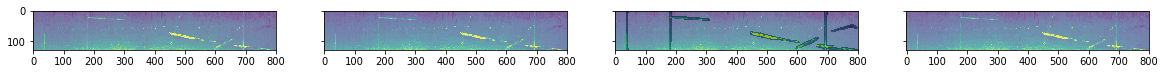

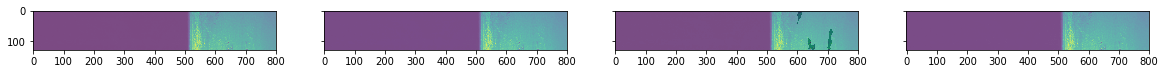

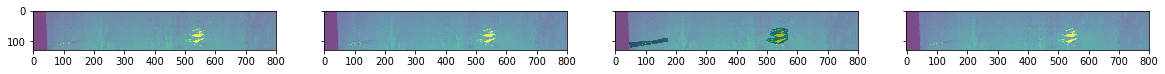

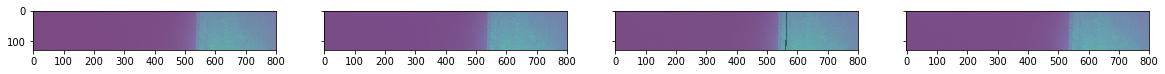

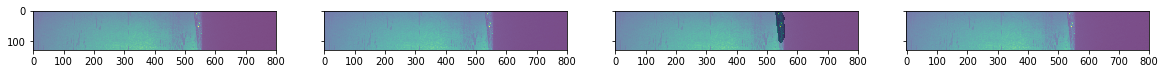

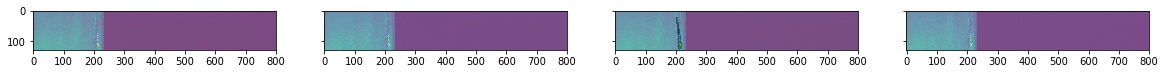

In [16]:
for ix in range(0,batch_size):
    if y[ix].sum() > 0:
        img = x[ix][...,0]
        masks_temp = [y[ix][...,i] for i in range(0,4)]
        viz_steel_img_mask(img, masks_temp)

In [17]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # print((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    # print(K.sum(y_true_f).shape)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [18]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights=None, input_shape=(img_h,img_w,1), include_top=False)
base_model.trainable = False
def VGG_Unet():
  base_model = VGG16(weights=None, input_shape=(img_h,img_w,1), include_top=False)
  base_out = base_model.output
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (base_out)
  # u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  # u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  # u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  # u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
  # u9 = concatenate([u9, c1], axis=3)
  c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
  c10 = Dropout(0.1) (c10)
  c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

  outputs = Conv2D(4, (1, 1), activation='sigmoid') (c10)
  model = Model(input=base_model.input, output=outputs)

  model.compile(optimizer = keras.optimizers.Adam(lr=0.0001),loss = 'binary_crossentropy',metrics = [dice_coef])
  return model

In [19]:
model = VGG_Unet()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 800, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 800, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 400, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 400, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 400, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 200, 128)      0   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [20]:
model.load_weights('../input/weights/vgg_unet_weights_25.h5')
# history = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=1, verbose=1)

In [21]:
model_save_path = './vgg_unet_weights1.h5' 
model.save(model_save_path)

In [22]:
# # summarize history for accuracy
# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.plot(history.history['dice_coef'])
# plt.plot(history.history['val_dice_coef'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')

# # summarize history for loss
# plt.subplot(1,2,2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')

In [23]:
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    if np.sum(union) == 0:
        iou_score = 0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [24]:
def viz_single_fault(img, mask, pred, image_class):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
    
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    
    ax[0].imshow(img)
    ax[0].imshow(mask, alpha=0.3, cmap=cmaps[image_class-1])
    ax[0].set_title('Mask - Defect Class %s' % image_class)
    
    ax[1].imshow(img)
    ax[1].imshow(pred, alpha=0.3, cmap=cmaps[image_class-1])
    ax[1].set_title('Predicted Mask - Defect Class %s' % image_class)
    
    plt.show()

In [25]:
# count = 0
# # a list to keep count of the number of plots made per image class
# class_viz_count = [0,0,0,0]
# # to keep the total iou score per image class
# class_iou_score = [0, 0, 0, 0]
# # to keep sum of mask pixels per image class
# class_mask_sum = [0, 0, 0, 0]
# # to keep sum of predicted mask pixels per image class
# class_pred_sum = [0, 0, 0, 0]

# # loop over to all the batches in one epoch 
# for i in range(0, validation_generator.__len__()):
#     # get a batch of image, true mask, and predicted mask
#     x, y = validation_generator.__getitem__(i)
#     predictions = model.predict(x)

#     # loop through x to get all the images in the batch
#     for idx, val in enumerate(x):
#         # we are only interested if there is a fault. if we are dropping images with no faults before this will become redundant
#         if y[idx].sum() > 0: 
#             # get an image and convert to make it matplotlib.pyplot friendly
#             img = x[idx][...,0]
# #             img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
#             # loop over the four ourput layers to create a list of all the masks for this image
#             masks_temp = [y[idx][...,i] for i in range(0,4)]
#             # loop over the four output layers to create a list of all the predictions for this image
#             preds_temp = [predictions[idx][...,i] for i in range(0,4)]
#             # turn to binary (prediction) mask 
#             preds_temp = [p > .5 for p in preds_temp]

#             for i, (mask, pred) in enumerate(zip(masks_temp, preds_temp)):
#                 image_class = i + 1
#                 class_iou_score[i] += calculate_iou(mask, pred)
#                 class_mask_sum[i] += mask.sum()
#                 class_pred_sum[i] += pred.sum()
#                 if mask.sum() > 0 and class_viz_count[i] < 5:
#                     viz_single_fault(img, mask, pred, image_class)
#                     class_viz_count[i] += 1

In [26]:
# class_ids = [1,2,3,4]
# plt.figure(figsize=(20,5))
# plt.subplot(1,3,1)
# y_pos = np.arange(len(class_ids))
# plt.bar(y_pos, class_iou_score)
# plt.xticks(y_pos, class_ids)
# plt.title('IoU score per class')
# plt.ylabel('IoU Sum')
# plt.xlabel('class id')
# plt.subplot(1,3,2)
# plt.bar(y_pos, class_mask_sum)
# plt.xticks(y_pos, class_ids)
# plt.title('labeled mask pixel sum per class')
# plt.ylabel('pixel sum')
# plt.xlabel('class id')
# plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# plt.subplot(1,3,3)
# plt.bar(y_pos, class_pred_sum)
# plt.xticks(y_pos, class_ids)
# plt.title('predicted mask pixel sum per class')
# plt.ylabel(' pixel sum')
# plt.xlabel('class id')
# plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# plt.show()

In [27]:
def get_test_tensor(img_dir, img_h, img_w, channels=1):

    X = np.empty((1, img_h, img_w, channels))
    # Store sample
    image = cv2.imread(img_dir, 0)
    image_resized = cv2.resize(image, (img_w, img_h))
    image_resized = np.array(image_resized, dtype=np.float64)
    # normalize image
    image_resized -= image_resized.mean()
    image_resized /= image_resized.std()
    
    X[0,] = np.expand_dims(image_resized, axis=2)

    return X

In [28]:
from skimage import morphology

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [29]:
import glob
# get all files using glob
test_files = [f for f in glob.glob('../input/severstal-steel-defect-detection/train_images/' + "*.jpg", recursive=True)]
test_files = test_files[:100]

In [30]:
test_df = pd.read_csv(os.path.join(train_dir, 'sample_submission.csv'))
test_df['ImageId'] = test_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_df['ClassId'] = test_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
test_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId
0,004f40c73.jpg_1,1 1,004f40c73.jpg,1
1,004f40c73.jpg_2,1 1,004f40c73.jpg,2
2,004f40c73.jpg_3,1 1,004f40c73.jpg,3
3,004f40c73.jpg_4,1 1,004f40c73.jpg,4
4,006f39c41.jpg_1,1 1,006f39c41.jpg,1


In [31]:
test_image_ids = test_df['ImageId'].unique()
print(test_image_ids[1])

006f39c41.jpg


In [32]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [33]:
submission = []
def process_pred_mask(pred_mask):
    pred_mask = cv2.resize(pred_mask.astype('float32'),(1600, 256))
    #pred_mask = (pred_mask > .5).astype(int)
    #pred_mask = remove_small_regions(pred_mask, 0.02 * np.prod(512)) * 255
    pred_mask = mask2rle(pred_mask)
    print(len(pred_mask))
    return pred_mask

# loop over all the test images
for f in test_files:
    # get test tensor, output is in shape: (1, 256, 512, 3)
    test = get_test_tensor(f, img_h, img_w) 
    # get prediction, output is in shape: (1, 256, 512, 4)
    pred_masks = model.predict(test) 
   
    # get a list of masks with shape: 256, 512
    pred_masks = [pred_masks[0][...,i] for i in range(0,4)]
    
    # apply all the processing steps to each of the mask
    
    pred_masks = [process_pred_mask(pred_mask) for pred_mask in pred_masks]
    #break
    # get our image id
    id = f.split('/')[-1]
    # create ImageId_ClassId and get the EncodedPixels for the class ID, and append to our submissions list
    [submission.append((id+'_%s' % (k+1), pred_mask)) for k, pred_mask in enumerate(pred_masks)]

16639
16808
13862
7844
28159
13276
27101
13177
13447
14236
12833
3468
4298
12665
4429
37024
21565
49130
41505
55114
19863
8466
19788
8291
19861
10308
21260
5402
15544
12135
14532
8289
13940
17949
13333
7562
14789
12164
13726
5837
20866
10593
20485
9356
15035
13566
14462
4405
14982
13356
15061
6912
28061
15059
28570
16831
21173
4966
19954
7875
11552
13200
11310
4721
21800
6481
19020
8860
16601
15172
14685
6436
19612
11516
20267
8051
13941
11645
16069
5051
22599
12021
22494
9319
23999
9763
25329
3520
19641
7753
20909
7927
5198
69248
6942
14494
23909
11419
22276
9683
19068
11074
19618
8885
1255
70950
24732
34448
20064
16819
19208
12981
26065
12386
25591
12361
22974
28195
27889
23520
24017
9581
26047
10882
24796
9876
26114
9453
14528
11659
12877
7758
8566
14877
9834
5454
27015
6849
23557
9440
27600
17284
30002
19806
25206
35069
49300
50483
6167
13566
10260
52712
4685
62698
4508
8597
12150
12232
12459
6331
15948
11618
15748
5924
3270
32092
2640
79349
20080
8624
19408
9250
10917
14243
10877


In [34]:
# convert to a csv
submission_df = pd.DataFrame(submission, columns=['ImageId_ClassId', 'EncodedPixels'])
# check out some predictions and see if RLE looks ok
submission_df[ submission_df['EncodedPixels'] != ''].head()

,ImageId_ClassId,EncodedPixels
0,62a1af2c1.jpg_1,0 15109 15111 254 15367 254 15625 252 15881 25...
1,62a1af2c1.jpg_2,0 937 941 252 1197 232 1505 6 1513 172 1761 6 ...
2,62a1af2c1.jpg_3,0 16161 16163 254 16419 244 16667 6 16675 24 1...
3,62a1af2c1.jpg_4,0 2001 2003 254 2259 220 2483 8 2499 4 2515 22...
4,b1d3f12b6.jpg_1,0 941 945 28 977 8 993 204 1201 28 1233 8 1249...


In [35]:
# take a look at our submission 
submission_df.head()

,ImageId_ClassId,EncodedPixels
0,62a1af2c1.jpg_1,0 15109 15111 254 15367 254 15625 252 15881 25...
1,62a1af2c1.jpg_2,0 937 941 252 1197 232 1505 6 1513 172 1761 6 ...
2,62a1af2c1.jpg_3,0 16161 16163 254 16419 244 16667 6 16675 24 1...
3,62a1af2c1.jpg_4,0 2001 2003 254 2259 220 2483 8 2499 4 2515 22...
4,b1d3f12b6.jpg_1,0 941 945 28 977 8 993 204 1201 28 1233 8 1249...


In [36]:
# write it out
submission_df.to_csv('./submission.csv', index=False)